In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Open Gridmet max temperature with geopandas and plot

0 nhru_01.zip
1 nhru_02.zip
nhru_02.shp
     POI_ID  hru_id_nat  hru_id_reg region  \
0  10054896        2463           1     02   
1  10054896        2464           2     02   
2  10054884        2465           3     02   
3  10054884        2466           4     02   
4   8526515        2467           5     02   

                                            geometry  
0  POLYGON ((-76.58883845899999 36.74653056200003...  
1  (POLYGON ((-76.46904191499993 36.7791440250000...  
2  POLYGON ((-76.65698387399993 36.85365225800007...  
3  POLYGON ((-76.62364401799994 36.86489843200007...  
4  POLYGON ((-79.99363256999999 37.44257329500005...  


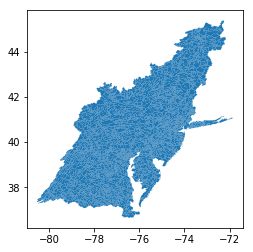

In [2]:
directory = r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru'
unzip_dir = r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip'
os.chdir(directory)
# filenames = glob.glob('*_[0-1]*.zip')
for idx, name in enumerate(glob.glob('*_[0-1]*.zip')):
    print(idx, name)
    if idx == 1: # for testing we just open the second file
        #unzip file
        zip_ref = zipfile.ZipFile(name, 'r')
        zip_ref.extractall(unzip_dir)
        zip_ref.close()
        (prefix, sep, suffix) = name.rpartition('.')
        shp_name = prefix+r'.shp'
        os.chdir(unzip_dir)
        print(shp_name)
        data = gpd.read_file(shp_name)
        print(data.head())
        break
data.plot()

# Open Gridmet data (as netcdf file) and save as geotiff raster
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [3]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
dirPath='http://thredds.northwestknowledge.net:8080'
fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'

#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath+fileName
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
datahandle=ds['air_temperature']
crshandle=ds['crs']
print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)


dayshape,lonshape,latshape = datahandle.values.shape


datahandle.values[dayshape-1,:,:].shape

print(lathandle.values.shape)
print(type(lathandle.values))
print(datahandle.dtype)
print(np.isfortran(datahandle.values))

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_2019.nc
<xarray.Dataset>
Dimensions:          (crs: 1, day: 93, lat: 585, lon: 1386)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 25.07 25.11 25.15 25.19 ... 49.32 49.36 49.4
  * day              (day) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-04-03
  * crs              (crs) int32 1
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial

# Convert netcdf to geotiff

In [5]:
lat = lathandle.values
lon = lonhandle.values

transform = from_origin( lonmin, latmax, lonres, latres)
# res = (lon[-1] - lon[0])/lon.shape[0]
# print(res)
# transform2 = from_origin(lon[0]-res/2, lat[-1]+res/2, res, res) 
# print(transform, transform2)
new_dataset = rasterio.open(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif', 'w', driver='GTiff',
                            height = lonshape, width = latshape,
                            count=1, dtype=str(datahandle.dtype),
                            crs={'init': 'epsg:4326'},
                            transform=transform)
# vals = np.transpose(datahandle.values, [1,2,0])
# vals2 = vals[:,:,85-1]
vals = datahandle.values[dayshape-1, :, :]
print(vals.shape)
# im = np.transpose(vals, [1,2,0])
# fa = np.asfortranarray(vals)
# ca = np.asanyarray(vals, order='C')
ud = (np.flipud(vals)-273.15) * 9/5 + 32
# at = np.transpose(vals)
# atf = np.rot90(at)
new_dataset.write(ud, 1)
# new_dataset.warp.transform
# print(new_dataset.transform)
# pyplot.imshow(new_dataset.read(1), cmap='pink')
# pyplot.show()
print(new_dataset)
new_dataset.close()

(585, 1386)
<open DatasetWriter name='C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif' mode='w'>


# Plot geotiff raster data

<class 'affine.Affine'> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1386, 'height': 585, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.041666666666666, 0.0, -124.7666666333333,
       0.0, -0.041666666666666, 49.4)}
<closed DatasetReader name='test1.tif' mode='r'>


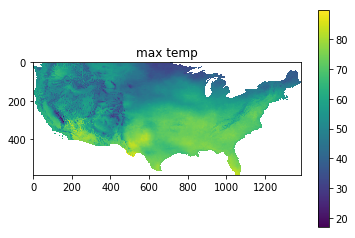

In [6]:
os.chdir(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip')
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)
print(src)
plt.imshow(array, interpolation='nearest')
plt.colorbar()
plt.title('max temp')
plt.show()
src.close()

# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

| 0.04, 0.00,-124.77|
| 0.00,-0.04, 49.40|
| 0.00, 0.00, 1.00|
<class 'affine.Affine'> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1386, 'height': 585, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.041666666666666, 0.0, -124.7666666333333,
       0.0, -0.041666666666666, 49.4)}


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\rasterstats\io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


   count        max       mean        min
0      4  69.095993  68.928110  68.669785
1     15  69.315941  68.946970  68.511520
2     11  70.504166  69.789582  68.940811
3      6  69.803902  69.413336  68.940811
4      4  66.067780  65.574535  65.123726


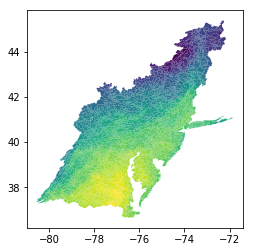

In [7]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='mean', cmap='viridis')

In [8]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [9]:
print(statsdf)
print(zonalhru)
zonalhru.to_file('nhru_02_rs.shp', driver='ESRI Shapefile')

      count        max       mean        min
0         4  69.095993  68.928110  68.669785
1        15  69.315941  68.946970  68.511520
2        11  70.504166  69.789582  68.940811
3         6  69.803902  69.413336  68.940811
4         4  66.067780  65.574535  65.123726
5        11  69.350662  68.716434  68.008186
6        16  69.077431  68.508403  67.897720
7         5  66.703171  65.800262  65.123726
8        10  64.688499  62.800637  60.502983
9        13  66.074097  64.030334  61.536358
10        7  65.268578  63.817393  60.502983
11       19  67.196899  64.947159  61.536358
12       12  64.688499  62.143921  60.414436
13       22  68.916260  67.991419  67.150925
14        8  68.282516  67.937407  67.624489
15       21  67.843063  67.213188  66.618195
16        6  68.214066  68.003085  67.843063
17       30  67.843063  66.503034  65.694023
18       23  70.194412  69.065476  67.938583
19        7  69.856087  69.424715  69.058861
20        1  69.058861  69.058861  69.058861
21        

In [10]:
from affine import Affine
da = xr.open_rasterio('test1.tif')
print(da)
crs = ccrs.Orthographic()
ax = plt.subplot(projection=crs)
da.plot(ax=ax, transform=crs)
ax.coastlines('10m', color='r')
plt.show()

# da.plot()
# da.imshow(da)
# transform2 = Affine.from_gdal(*da.attrs['transform'])
# print(transform2)
# nx, ny = da.sizes['x'], da.sizes['y']
# x, y = np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5) * transform

# da.close()
# # ax = plt.axes(projection=ccrs.Orthographic())             
# # da['band'][0].plot.pcolormesh(ax=ax, transform=ccrs.Orthographic(), x=x, y=y,add_colorbar=True)
# # da.plot()


<xarray.DataArray (band: 1, y: 585, x: 1386)>
[810810 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 49.38 49.34 49.3 49.25 ... 25.17 25.13 25.09 25.05
  * x        (x) float64 -124.7 -124.7 -124.7 -124.6 ... -67.12 -67.08 -67.04
Attributes:
    transform:   (0.041666666666666, 0.0, -124.7666666333333, 0.0, -0.0416666...
    crs:         EPSG:4326
    res:         (0.041666666666666, 0.041666666666666)
    is_tiled:    0
    nodatavals:  (nan,)


NameError: name 'ccrs' is not defined

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
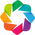

<class 'xarray.core.dataarray.DataArray'> OrderedDict([('transform', (0.041666666666666, 0.0, -124.7666666333333, 0.0, -0.041666666666666, 49.4)), ('crs', 'EPSG:4326'), ('res', (0.041666666666666, 0.041666666666666)), ('is_tiled', 0), ('nodatavals', (nan,))]) nan
<class 'geoviews.element.geo.Dataset'>


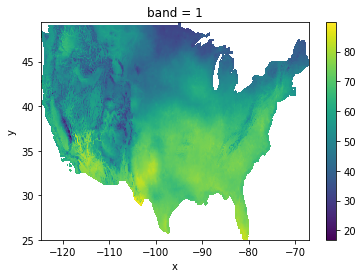

In [46]:
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

gv.extension('bokeh', 'matplotlib')
da2 = xr.open_rasterio('test1.tif')
da2.plot()
print(type(da2), da2.attrs, np.min(da2.values))
dataset = gv.Dataset(da2.values)
print(type(dataset))
# ensemble = dataset.to(gv.Image, ['lon', 'lat'], 'air_temperature')

# gv.output(ensemble.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')